### Discrimination

<h4>ROC Curve (Receiver Operating Characteristic Curve)</h4>

<div class="alert alert-block alert-info">
A Receiver Operating Characteristic curve, often referred to as the <b>ROC curve</b>, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The <b>ROC curve</b> is created by plotting the <b>True Positive Rate (TPR)</b> against the <b>False Positive Rate (FPR)</b> at various threshold settings.</div>

In [1]:
import numpy as np
import pandas as pd

np.random.seed(0)

import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [2]:
# Generate a synthetic dataset

X, y = make_classification(
    n_samples=50000,
    n_features=15,
    weights=[0.90, 0.10],
    n_classes=2,
    n_informative=5,
    random_state=42,
)

X, y = pd.DataFrame(X), pd.DataFrame(y)

X.columns = [f"feature_{i+1}" for i in range(len(X.columns))]

ix_train, ix_test = train_test_split(X.index, stratify=y, random_state=62)

In [3]:
# Create an XGBoost model with random forests
model_gbdt = xgb.XGBClassifier(
    booster="gbtree",
    max_depth=3,
    subsample=0.5,
    colsample_bynode=0.2,
    eval_metric=["logloss", "auc"],
    early_stopping_rounds=10,
)

evalset = [(X.loc[ix_train], y.loc[ix_train]), (X.loc[ix_test], y.loc[ix_test])]

# Fit the model to the generated dataset
model_gbdt.fit(X.loc[ix_train], y.loc[ix_train], eval_set=evalset)

[0]	validation_0-logloss:0.31868	validation_0-auc:0.74799	validation_1-logloss:0.32003	validation_1-auc:0.73429
[1]	validation_0-logloss:0.31147	validation_0-auc:0.77143	validation_1-logloss:0.31330	validation_1-auc:0.75790
[2]	validation_0-logloss:0.29090	validation_0-auc:0.80875	validation_1-logloss:0.29277	validation_1-auc:0.79646
[3]	validation_0-logloss:0.25391	validation_0-auc:0.87448	validation_1-logloss:0.25929	validation_1-auc:0.85711
[4]	validation_0-logloss:0.23867	validation_0-auc:0.87743	validation_1-logloss:0.24538	validation_1-auc:0.86018
[5]	validation_0-logloss:0.23249	validation_0-auc:0.87962	validation_1-logloss:0.23899	validation_1-auc:0.86309
[6]	validation_0-logloss:0.22075	validation_0-auc:0.88028	validation_1-logloss:0.22876	validation_1-auc:0.86379
[7]	validation_0-logloss:0.20951	validation_0-auc:0.88844	validation_1-logloss:0.21681	validation_1-auc:0.87391
[8]	validation_0-logloss:0.20340	validation_0-auc:0.89566	validation_1-logloss:0.21060	validation_1-auc:

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.2,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['logloss', 'auc'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [4]:
def get_roc_curve(y_test, y_proba, delta=0.1):
    """
    Return the True Positive Rates (TPRs), False Positive Rates (FPRs),
    and the threshold values, seperated by delta.
    """
    thresh = list(np.arange(0, 1, delta)) + [1]
    TPRs = []
    FPRs = []
    y_pred = np.empty(y_proba.shape)
    for th in thresh:
        y_pred[y_proba < th] = 0
        y_pred[y_proba >= th] = 1

        # confusion matrix
        (TN, FP), (FN, TP) = confusion_matrix(y_test, y_pred)
        TPR = TP / (TP + FN)  # sensitivity
        FPR = FP / (FP + TN)  # 1 - specificity
        TPRs.append(TPR)
        FPRs.append(FPR)
    return FPRs, TPRs, thresh

Here, <code>delta</code> is the difference between each of the thresholds at which ROC curve is calculated.

In [5]:
delta = 0.001
y_proba = model_gbdt.predict_proba(X.loc[ix_test])[:, 1]
FPRs, TPRs, _ = get_roc_curve(y.loc[ix_test], y_proba, delta)

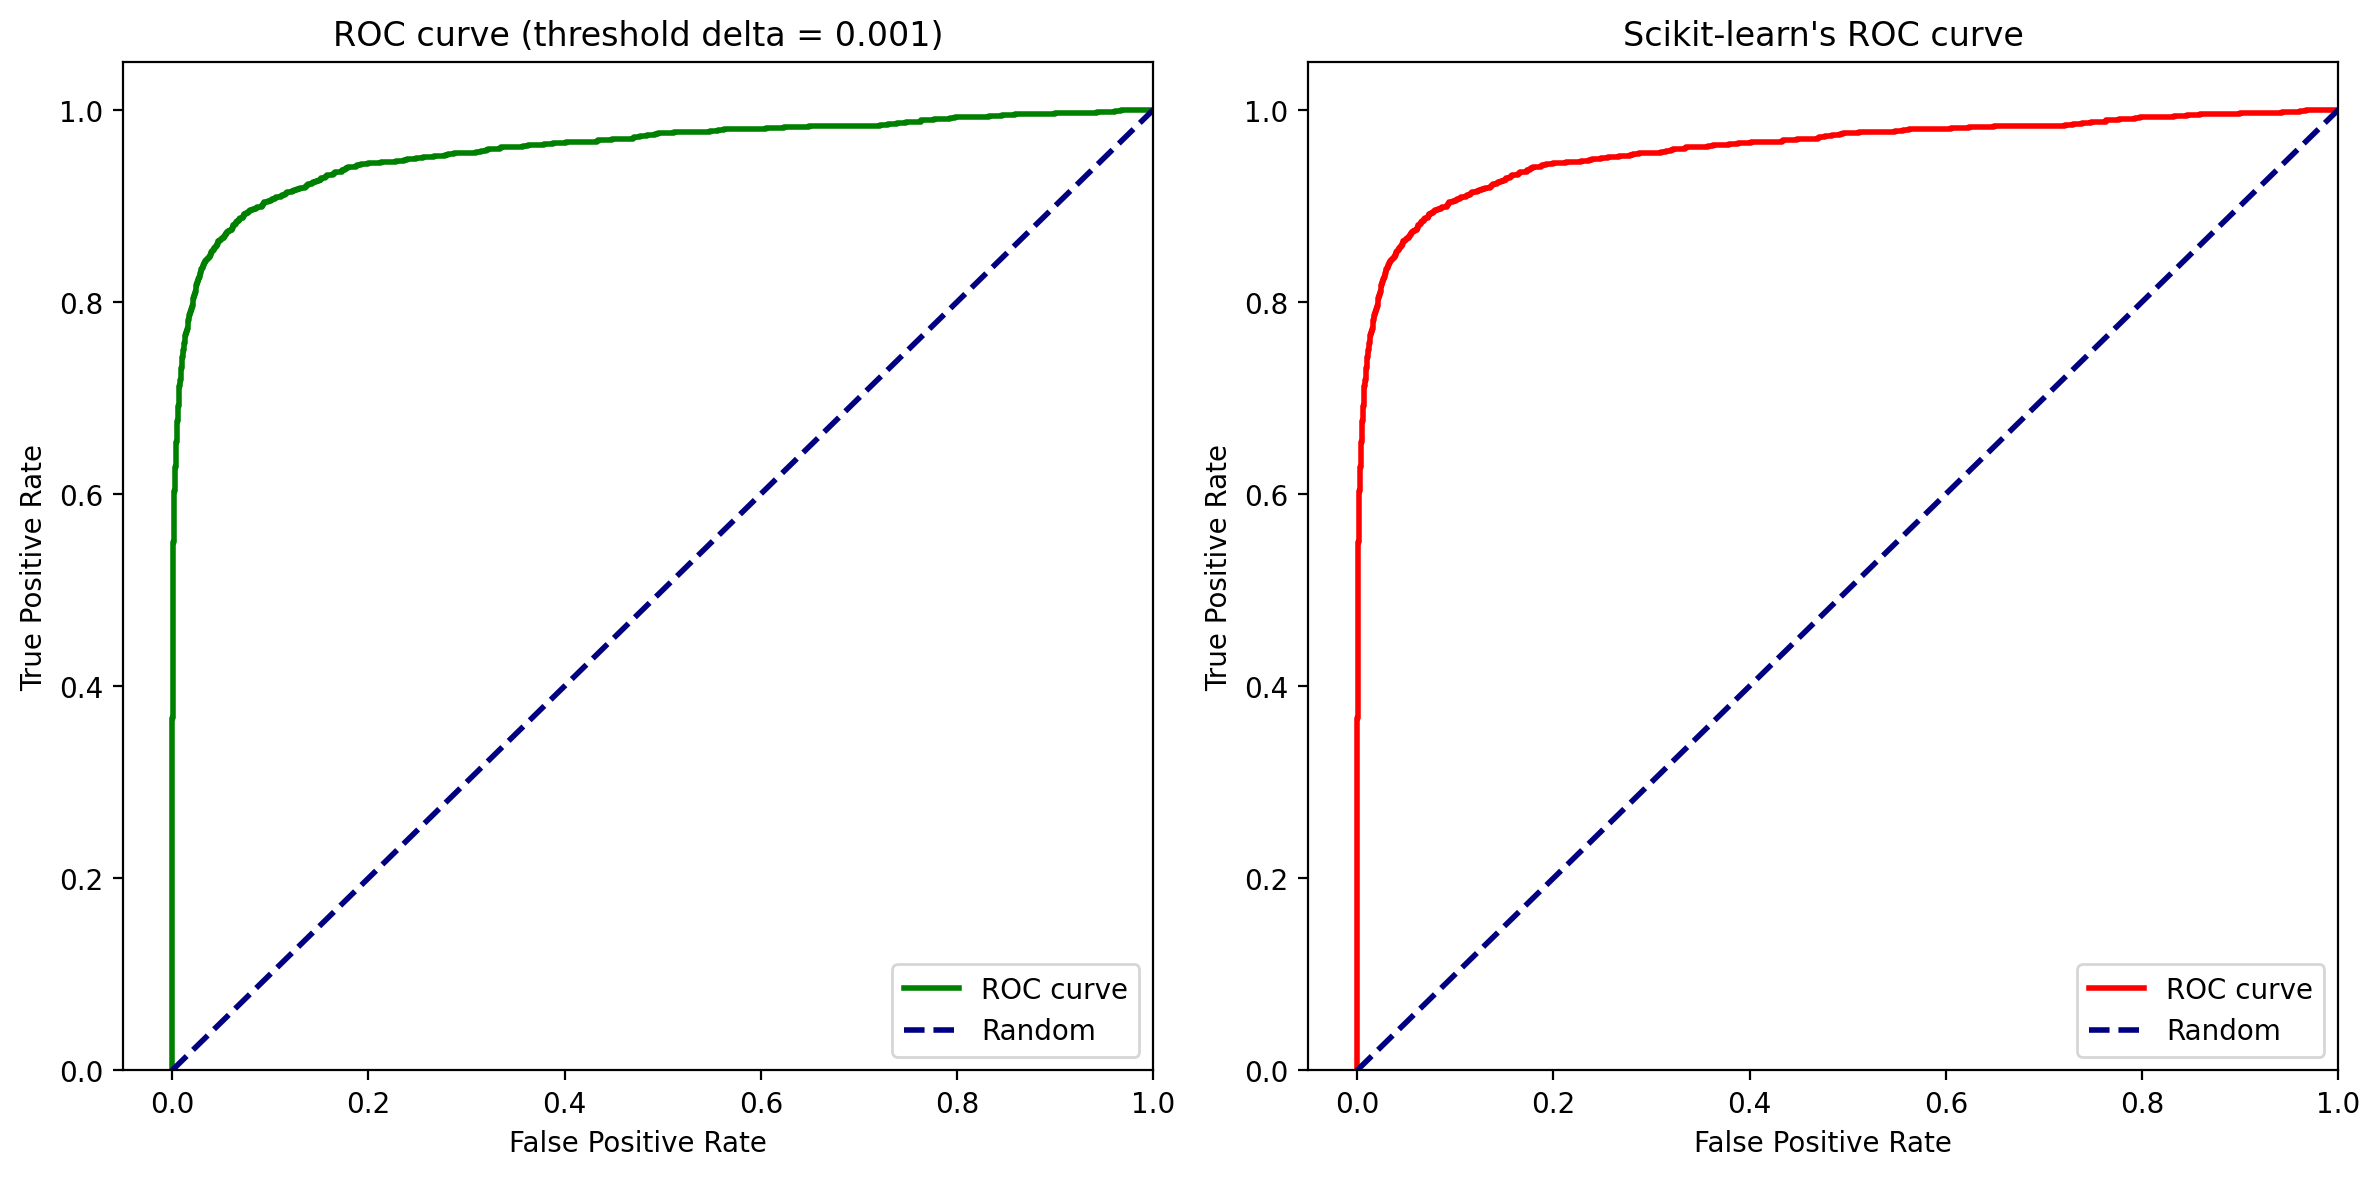

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First subplot (Left side)
ax = axs[0]

# Calculate ROC curve for your data
FPRs, TPRs, _ = roc_curve(y.loc[ix_test], y_proba)

# Plot the ROC curve on the first subplot
ax.plot(FPRs, TPRs, color="g", lw=2, label="ROC curve")
ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random")
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title(f"ROC curve (threshold delta = {delta})")
ax.legend(loc="lower right")

# Second subplot (Right side)
ax = axs[1]

# Calculate ROC curve for sklearn implementation
FPRs, TPRs, _ = roc_curve(y.loc[ix_test], y_proba)

# Plot the ROC curve on the second subplot
ax.plot(FPRs, TPRs, color="red", lw=2, label="ROC curve")
ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random")
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Scikit-learn's ROC curve")
ax.legend(loc="lower right")

# Display the subplots
plt.tight_layout()
plt.show()

We can see that implementation of the ROC Curve is aligned with Scikit-Learn and gives consistent results.

<h4>Gini score</h4>

<div class="alert alert-block alert-info">
Now, that we know about ROC curve, <b>AUC score</b> and <b>Gini score</b> are straightforward to understand.
AUC stands for <b>Area under the Curve</b>, which is nothing but the area under the ROC curve formed by the predictions.  
As we saw, a totally random prediction will have AUC score <code>0.5</code>, while a perfect classifier will have AUC score of <code>1</code>. The Gini score is a rescaled AUC score: <code>Gini=AUC*2-1</code>.</div>

Lets check the AUC and Gini score of our model.

In [7]:
auc_score = roc_auc_score(y.loc[ix_test], y_proba)
print(f"AUC score: {auc_score: .4f}")
print(f"Gini score: {auc_score*2-1: .4f}")

AUC score:  0.9580
Gini score:  0.9161


<h4>Profit curve</h4>

<div class="alert alert-block alert-info">
Profit curve is an extension of ROC Curve analysis for cost-sensitive learning.</div>

|  Prediction       | Default +               | Default -          |
| --------- | ---------------------- | ------------------ |
| Predicted Default + | {0} Correctly Predict Default |{-avg_profit}	Falsely Predict Default |
| Predicted Default - | {-avg_loss} Falsely Predict Non-Default | {avg_profit} Correctly Predict Non-Default |

In [8]:
# Define cost-benefit matrix based on observed losses and profits
# [tp, fp], [fn, tn]: [Loss incurred, Profit lost, Loss incurred, Profit made]
avg_profit, avg_loss = 1430, 1454
cost_benefit_matrix = np.array([[0, -avg_profit], [-avg_loss, avg_profit]])
print(cost_benefit_matrix)

[[    0 -1430]
 [-1454  1430]]


In [9]:
def standard_confusion_matrix(y_true, y_pred):
    """
    Reformat confusion matrix output from sklearn for plotting profit curve.
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])


def plot_profit_curve(
    cost_benefit_matrix, y_true: np.ndarray, y_proba: np.ndarray, **kwargs
):
    """
     Plot profit curve.

     Inputs:
     - model object
     - cost benefit matrix in the same format as the confusion matrix above
     - predicted probabilities
     - actual labels
    - additional kwargs for matplotlib
    """

    # Profit curve data
    profits = []  # one profit value for each T (threshold)
    thresholds = sorted(y_proba, reverse=True)

    # For each threshold, calculate profit - starting with largest threshold
    for T in thresholds:
        y_pred = (y_proba > T).astype(int)
        confusion_mat = standard_confusion_matrix(y_true, y_pred)
        # Calculate total profit for this threshold
        profit = sum(sum(confusion_mat * cost_benefit_matrix) / len(y_true))
        profits.append(profit)

    # Profit curve plot
    plt.plot(np.linspace(0, 1, len(y_true)), profits, **kwargs)

    return profits

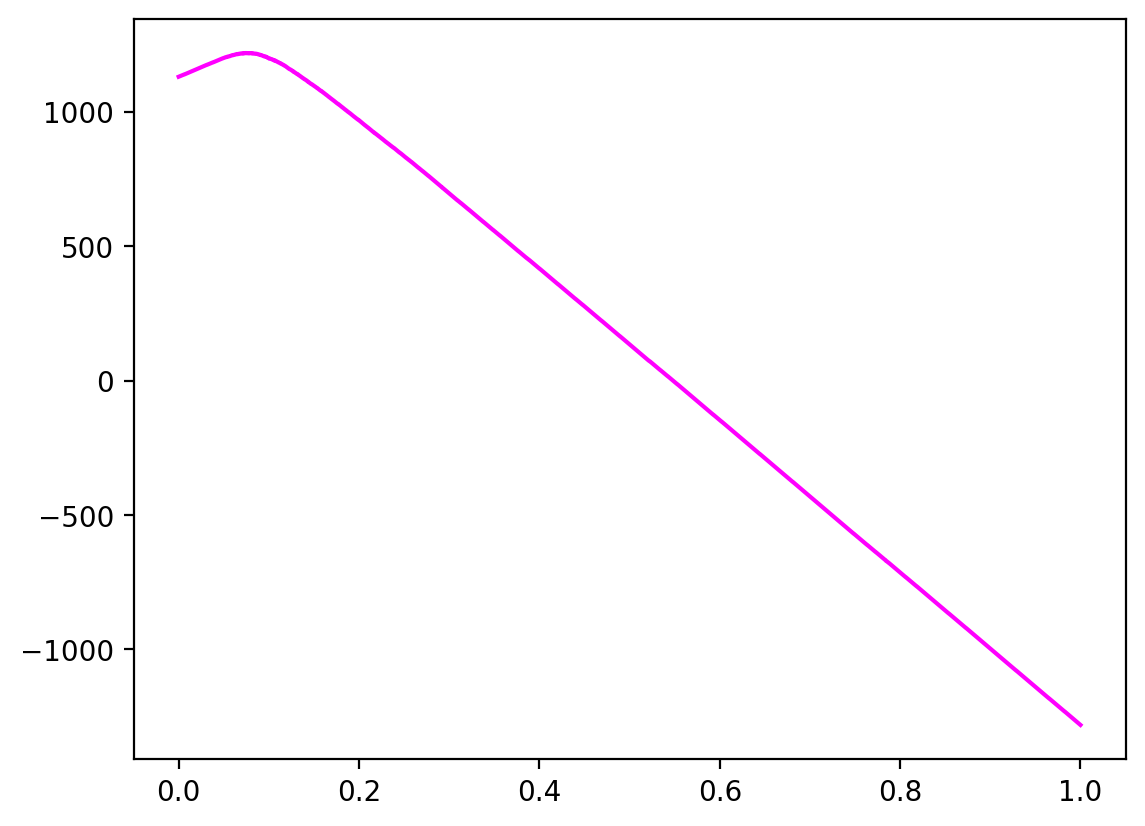

In [10]:
plot_profit_curve_df = plot_profit_curve(
    cost_benefit_matrix,
    y.loc[ix_test],
    y_proba,
    color="fuchsia",
)

<h4>Somers' D score</h4>

<div class="alert alert-block alert-info">
<b>Somers' D</b>, often referred to as Somers' D statistic or Somers' Rank Correlation Coefficient, is a measure of the strength and direction of association between two ordinal variables. In case of binary classification, Somers'D and Gini score mean the same metric. For ordinal rankings, binning is recommended.</div>

In [11]:
from scipy.stats import somersd
from sklearn.datasets import make_regression
from xgboost import XGBRFRegressor

In [12]:
# Create a synthetic regression dataset
X, y = make_regression(n_samples=10000, n_features=25, noise=100, random_state=0)

X, y = pd.DataFrame(X), pd.DataFrame(y)

X.columns = [f"feature_{i+1}" for i in range(len(X.columns))]

ix_train, ix_test = train_test_split(X.index, test_size=0.2, random_state=62)

In [13]:
xgb_rf = XGBRFRegressor(n_estimators=100, max_depth=10)
xgb_rf.fit(X.loc[ix_train], y.loc[ix_train])

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=10, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, reg_alpha=None, ...)

In [14]:
predictions = xgb_rf.predict(X.loc[ix_test])

In [15]:
# numpy cross-tab
contingency_table = np.histogram2d(
    y.loc[ix_test].values.flatten(), predictions.flatten(), bins=200
)[0]

res = somersd(contingency_table)
somers_d_score = res.statistic

print(f"gAUC score: {(somers_d_score + 1)/2:.2%}")
print(f"Somers' D score: {somers_d_score:.2%}")

gAUC score: 79.83%
Somers' D score: 59.66%


<h4>Cumulative LGD Accuracy Ratio (CLAR)</h4>

<div class="alert alert-block alert-info">
Adapted from <a href="https://search.r-project.org/CRAN/refmans/VUROCS/html/clar.html">VUROCS: Volume under the ROC Surface for Multi-Class ROC Analysis</a>.
For the purpose of discriminatory power assessment, the predicted and realised LGDs are usually mapped to a discretised LGD scale.</div>

In [16]:
def clar(y: np.ndarray, X: np.ndarray) -> float:
    """Calculate Cumulative LGD Accuracy Ratio (CLAR).

    CLAR measures the ability of predicted LGD categories to discriminate
    realized LGD values according to Ozdemir and Miu 2009.

    Args:
        y (np.ndarray): Vector of realized LGD values
        X (np.ndarray): Vector of predicted LGD values

    Returns:
        CLAR value for the predicted and realized LGD categories (np.float)
        Share of observations as a numpy array (np.ndarray)
        Cumulative share of correctly assigned LGD values as a numpy array (np.ndarray)

    Raises:
        ValueError: If either 'X' or 'y' contains NA values
        ValueError: If 'X' and 'y' have different lengths

    References:
        Ozdemir, B., Miu, P., 2009. Basel II Implementation. A Guide to
        Developing and Validating a Compliant Internal Risk Rating System.
        McGraw-Hill, USA.
    """

    if any(pd.isna(X)) or any(pd.isna(y)):
        raise ValueError("Both 'X' and 'y' must not contain NA values")

    if len(X) != len(y):
        raise ValueError("Both 'X' and 'y' must be of the same length")

    nx = len(X)
    classes = sorted(list(set(X).union(set(y))), reverse=True)
    num = [sum(X == cls) for cls in classes]
    cnum = np.cumsum(num)
    index = np.argsort(X)[::-1]
    X = np.array(X)[index]
    y = np.array(y)[index]
    corr = np.zeros(len(classes))

    for i in range(len(classes) - 1):
        if cnum[i] > 0:
            corr[i] = np.sum(y[: cnum[i]] >= classes[i])

    corr /= nx
    corr[-1] = 1
    obs = cnum / nx

    res = obs[0] * corr[0] / 2
    for i in range(1, len(corr)):
        res += (corr[i] - corr[i - 1]) * (obs[i] - obs[i - 1]) / 2 + (
            obs[i] - obs[i - 1]
        ) * corr[i - 1]

    return res * 2, obs, corr

In [17]:
# generate a synthetic dataset
np.random.seed(0)

# Generate the first variable as random probabilities between 0 and 1
num_samples = 10000
lgd_observed = np.random.rand(num_samples)

# Create the second variable with a specified correlation to the first
correlation = 0.7  # correlation
lgd_predicted = correlation * lgd_observed + (1 - correlation) * np.random.rand(
    num_samples
)

# Ensure both variables are within the range [0, 1]
lgd_observed = np.clip(lgd_observed, 0, 1)
lgd_predicted = np.clip(lgd_predicted, 0, 1)

In [18]:
clar_score = clar(lgd_observed, lgd_predicted)[0]
print(f"CLAR: {clar_score:.4%}")

CLAR: 88.7468%


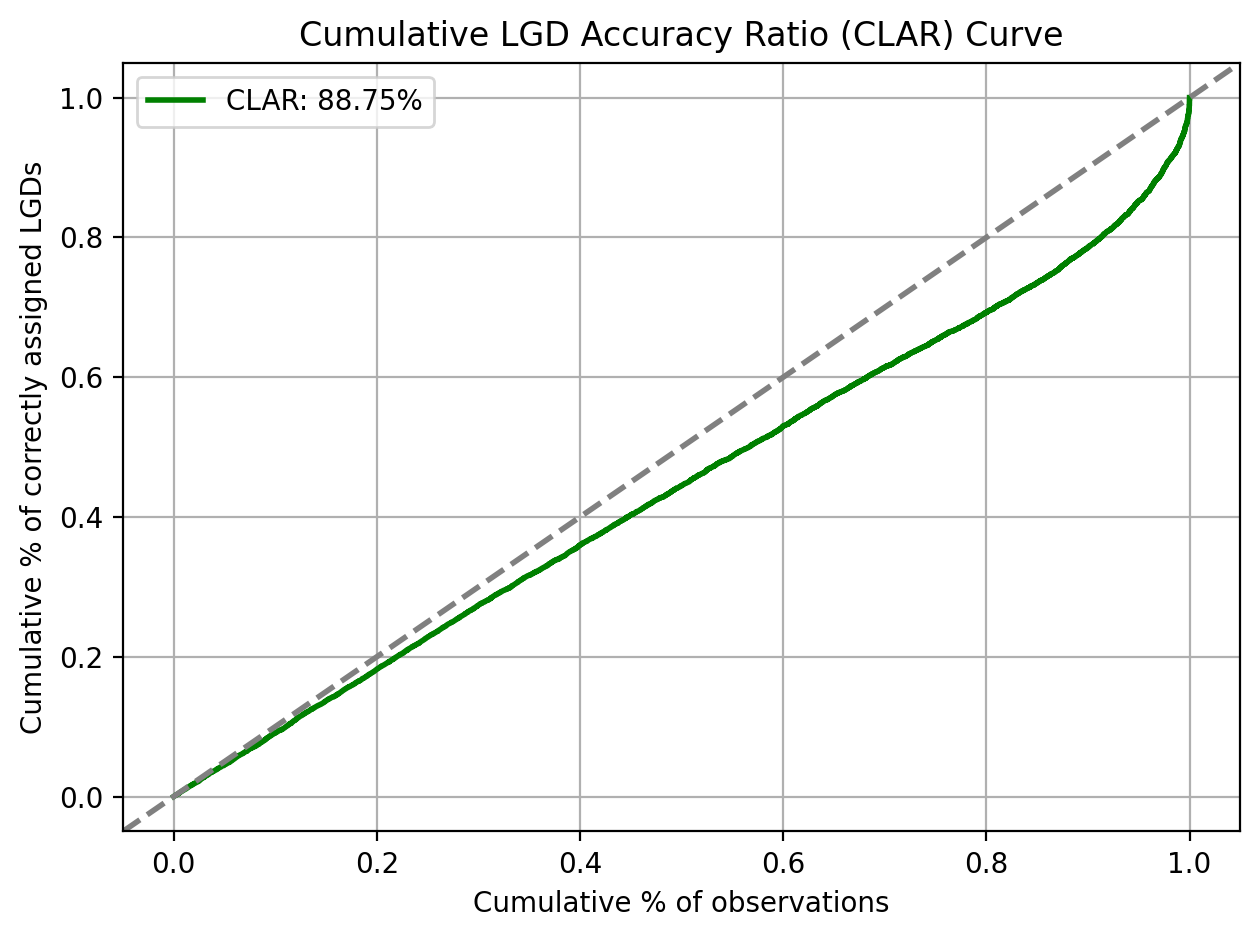

In [19]:
plt.figure()
plt.plot(
    clar(lgd_observed, lgd_predicted)[1],
    clar(lgd_observed, lgd_predicted)[2],
    color="g",
    linewidth=2,
    label=f"CLAR: {clar_score:.2%}",
)

# Add a horizontal line representing perfect discrimination
plt.axline((0, 0), slope=1, linestyle="--", linewidth=2, color="gray")

plt.xlabel("Cumulative % of observations")
plt.ylabel("Cumulative % of correctly assigned LGDs")
plt.title("Cumulative LGD Accuracy Ratio (CLAR) Curve")
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()